# Demo of the evolution model

The code in [amitosis.py](amitosis.py) was last tested with:

* python version 3.7.12
* numpy 1.20.3
* pandas 1.3.5
* matplotlib 3.4.2
* seaborn 0.11.1

Below we illustrate how to conduct the simulations used to generate Figure 5.  

## Parameters

* Genomic mutation rate: $U = 0.03$
* Beneficial effect of a mutation: $s = 0.03$
* Population size: $N=3000$
* Number of replicate populations: 16
* Number of fitness loci: $L=200$
* Number of loci fixed for a beneficial mutation: $K = 5$

In [1]:
run amitosis

In [2]:
sns.set_style('ticks')
sns.set_context('talk')

## Parental population

In [3]:
nReps = 16
pop = Populations(nReps=nReps, N=3000, nLoci=200, ploidy=45, genomic_mu=.03, selcoef=.03, amitosis=True)
for i in range(nReps):
    for j in range(5):  
        pop.soma[i,:,j] += 45
pop.get_fitness()
pop.collect_data()
data = pop.evolve(1000, 10) 
data

KeyboardInterrupt: 

## Progeny population

In [ ]:
nReps = 16
pop = Populations(nReps=nReps, N=3000, nLoci=200, ploidy=45, genomic_mu=.03, selcoef=.03, amitosis=True)
for i in range(nReps):
    for j in range(5):  
        pop.soma[i,:,j] += 22
    for j in range(5, 10):  
        pop.soma[i,:,j] += 23
pop.get_fitness()
pop.collect_data()
data2 = pop.evolve(1000, 10) 
data2

,fitness_mean,fitness_std,nReps,N,nLoci,ploidy,genomic_mu,selcoef,amitosis
0,1.160540,0.000000,16,3000,200,45,0.03,0.03,True
1,1.160563,0.000003,16,3000,200,45,0.03,0.03,True
2,1.160551,0.000089,16,3000,200,45,0.03,0.03,True
3,1.160623,0.000167,16,3000,200,45,0.03,0.03,True
4,1.160566,0.000218,16,3000,200,45,0.03,0.03,True
...,...,...,...,...,...,...,...,...,...
996,1.833435,0.076099,16,3000,200,45,0.03,0.03,True
997,1.834243,0.076200,16,3000,200,45,0.03,0.03,True
998,1.835349,0.076069,16,3000,200,45,0.03,0.03,True
999,1.836237,0.076233,16,3000,200,45,0.03,0.03,True


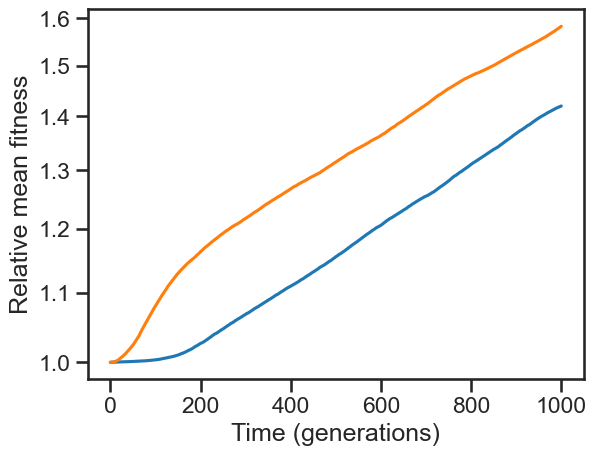

In [71]:
t = 
w1 = data['fitness_mean'] / data['fitness_mean'][0]
w2 = data2['fitness_mean'] / data2['fitness_mean'][0]
w1ci = 2.13145 * (data['fitness_std'] / data['fitness_mean'][0]) / 4
w2ci = 2.13145 * (data2['fitness_std'] / data2['fitness_mean'][0]) / 4 
plt.semilogy(w1)
plt.fill_between()
plt.plot(w2)
plt.yticks(ticks=np.arange(1, 1.61, .1), labels=np.arange(1, 1.61, .1).round(1))
plt.ylabel('Relative mean fitness')
plt.xlabel('Time (generations)');

In [44]:
nReps = 16
pop = Populations(nReps=nReps, N=3000, nLoci=200, ploidy=45, genomic_mu=.03, selcoef=.03, amitosis=True)
for i in range(nReps):
    for j in range(5):  
        pop.soma[i,:,j] += 22
    for j in range(5, 10):  
        pop.soma[i,:,j] += 23
pop.get_fitness()
pop.collect_data()

In [47]:
data2 = pop.evolve(900) 
data2

,fitness_mean,fitness_std,nReps,N,nLoci,ploidy,genomic_mu,selcoef,amitosis
0,1.160540,0.000000,16,3000,200,45,0.03,0.03,True
1,1.160563,0.000003,16,3000,200,45,0.03,0.03,True
2,1.160551,0.000089,16,3000,200,45,0.03,0.03,True
3,1.160623,0.000167,16,3000,200,45,0.03,0.03,True
4,1.160566,0.000218,16,3000,200,45,0.03,0.03,True
...,...,...,...,...,...,...,...,...,...
996,1.833435,0.076099,16,3000,200,45,0.03,0.03,True
997,1.834243,0.076200,16,3000,200,45,0.03,0.03,True
998,1.835349,0.076069,16,3000,200,45,0.03,0.03,True
999,1.836237,0.076233,16,3000,200,45,0.03,0.03,True


In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import time
import pickle

In [ ]:
class Populations(object):

    def __init__(self, nReps, N, nLoci, ploidy, genomic_mu, selcoef):
        '''Construct a set of populations consisting of unmutated individuals. 
        Each individual has germline and somatic genomes like Tetrahymena.  

        Mutation rates per site are identical between the genomes. Mutations may
        be beneficial or deleterious but have equal effects.

        Parameters
        ----------
        nReps : int
            Number of replicate populations.
        N : int
            Size of each population.
        nLoci : int
            Number of fitness loci.
        ploidy : int
            Ploidy of somatic genome.  (Germline genome is assumed to be diploid.)
        genomic_mu : float
            Mutation rate per genome per generation. 
        selcoef : float
            Selection coefficient of each mutation.  Positive and negative
            values represent beneficial and deleterious mutations, respectively.
        '''
        self.nReps = nReps
        self.N = N
        self.nLoci = nLoci
        self.soma = np.zeros((self.nReps, self.N, self.nLoci), dtype='int')
        self.germ = np.zeros((self.nReps, self.N, self.nLoci), dtype='int')
        self.ploidy = ploidy
        self.mu = genomic_mu / (nLoci * ploidy)
        self.selcoef = selcoef
        self.current_step = 0
        self.pop_mean_fit = []
        self.get_fitness()        

    def get_fitness(self):
        '''Calculate the fitness of each individual in each population.
        '''
        s = (self.soma / self.ploidy) * self.selcoef
        self.fitness = np.prod(1 + s, axis =2)
        self.relative_fitness = self.fitness / np.expand_dims(np.sum(self.fitness, axis=1), axis=1)
        
    def mutate(self):
        '''Mutate each locus in each genome in each individual in each population.
        '''
        self.soma += np.random.binomial(self.ploidy - self.soma, self.mu)
        self.germ += np.random.binomial(2 - self.germ, self.mu)
        self.get_fitness()
    
    def select(self):
        '''Sample N individuals with replacement with probability proportional
        to their fitness to form the next generation.
        '''      
        cumsum_fit = np.cumsum(self.relative_fitness, axis=1)
        random_vals = np.random.random((self.nReps, self.N))
        self.selected = map(np.searchsorted, cumsum_fit, random_vals)
    
    def reproduce(self, amitosis):
        '''Allow sampled individuals to reproduce asexually.  Germline genome
        reproduces mitotically.  Somatic genome reproduces amitotically or mitotically.

        Parameters
        ----------
        amitosis : bool
            Whether the soma reproduces by amitosis; if False, it reproduces by mitosis.
        '''
        rReps = np.ones((self.nReps, self.N), dtype='int') * np.expand_dims(np.arange(self.nReps), axis=1)
        print(rReps)
        self.germ = self.germ[rReps, self.selected, ]
        if amitosis:
            wildtype = (self.ploidy - self.soma[rReps, self.selected, ]) * 2
            mutant = self.soma[rReps, self.selected, ] * 2
            self.soma = np.random.hypergeometric(mutant, wildtype, self.ploidy)
        else:
            # mitosis in soma
            self.soma = self.soma[rReps, self.selected, ]
    
    def get_next_gen(self, asex_type='amitosis'):
        """Take populations through a single Wright-Fisher model generation"""
        self.mutate_all_before()
        parents = self.pick_parents_all()
        if asex_type == 'amitosis':
            self.amitosis_all(parents)
        elif asex_type == 'mitosis':
            self.mitosis_all(parents)
        self.current_step += 1
    
    def get_results(self):
        """calculate stuff like mean fitness, Gst, and number of fixed mutations"""
        W = self.fitness()
        mW = np.nanmean(W)
        log_mW = np.log(mW)
        pop_mean_fit = np.nanmean(W, axis =1)  # Calculate mean fitness from another way: first get the mean fitness of each population
        self.pop_mean_fit.append(pop_mean_fit)
        mean_fit = np.nanmean(pop_mean_fit)  # Then average across the populations
        pop_mfit_std = np.nanstd(pop_mean_fit)    # Get the STD of population mean fitness across each population
        total_fit_var = np.var(W, axis =1)
        varW_mean = np.nanmean(total_fit_var)  # Mean variance among populations
        varW_std = np.nanstd(total_fit_var)    # STD of variance among populations
        return [mW, log_mW, mean_fit, pop_mfit_std, varW_mean, varW_std]
        
    def simulate(self,stepcount, asex_type='amitosis',strides=10):
        results = [self.get_results()]
        # loci_fix = self.check_fixation()
        # total_loci_mut_fix = [loci_fix]
        start = time.time()
        while self.current_step <= stepcount:
            self.wright_fisher_step(asex_type)
            if self.current_step%strides == 0:
                results.append(self.get_results())
                # loci_fix = self.check_fixation()
                # total_loci_mut_fix.append(loci_fix)
        colnames = ['meanFit','ln_meanFit','PopMeanFit_Mean', 'PopMeanFit_STD', 'PopVar_Mean', 'PopVar_STD']
        results = pd.DataFrame(np.array(results),columns=colnames)
        end = time.time()
        print('TOTAL TIME: ',end-start)
        # total_loci_mut_fix = np.array(total_loci_mut_fix)
        # total_loci_mut_fix = np.transpose(total_loci_mut_fix, (1, 0, 2))        
        return results

    def simulateNsave(self,outfile, stepcount, asex_type='amitosis',strides=10):
        """same as simulate method except results are written to the file specified by outfile"""
        results = self.simulate(stepcount,asex_type,strides)
        results.to_csv(outfile,index=False)
        return

def save_file(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL) 

In [ ]:
pop = Populations(nReps=3, N=3, nLoci=5, ploidy=45, genomic_mu=5, selcoef=-0.2)
pop.mutate()
print('Soma')
print(pop.soma)
print('Germline')
print(pop.germ)

In [ ]:
rReps = np.ones((pop.nReps, pop.N), dtype='int') * np.expand_dims(np.arange(pop.nReps), axis=1)
rReps

In [ ]:
pop.soma[rReps, np.array([[1,1,1], [1,2,0], [0,0,0]]), ]

In [ ]:
pop.select()
pop.selected

In [ ]:
pop.reproduce(amitosis=False)
print('Soma')
print(pop.soma)
print('Germline')
print(pop.germ)

In [ ]:
pop.soma[1,1,:]

In [ ]:
pop.fitness

In [ ]:
pop.fitness.sum(axis=1)

In [ ]:
pop.relative_fitness

In [ ]:
pop.germ

In [ ]:
gmu = np.arange(start=0.01, stop= 0.11, step=0.01)
selcoef = np.arange(start=0.01, stop= 0.11, step=0.01)

total_combination = [[x,y] for x in gmu for y in selcoef]

save_file(total_combination, 'Total_GMU_Selcoef_Combination_Rv')


for i in range(100):

    a =Populations(nReps =16, nInds = 3000, nLoci = 200, ploidy =45, genomic_mu = total_combination[i][0], selcoef =total_combination[i][1])
    a.soma[:,:,:20] = 45

    a.simulateNsave('Fit_Amito_N3K_Parent_{}_L20R2.csv'.format(i), 1200, asex_type='amitosis',strides=1)
    save_file(a.pop_mean_fit, 'Pop_MFit_Parent_{}_L20R2'.format(i))



    b =Populations(nReps =16, nInds = 3000, nLoci = 200, ploidy =45, genomic_mu = total_combination[i][0], selcoef =total_combination[i][1])

    r = np.zeros((b.nReps, b.nLoci), dtype = 'int')
    r[:, :40] =1
    new_soma = b.soma[:, 0].copy() + r
    remain_allele = np.random.binomial(new_soma, 0.5)

    remain_allele[:, :40] = remain_allele[:, :40] + 22

    b.soma = np.repeat(remain_allele, b.nInds, axis =0).reshape(b.nReps, b.nInds, b.nLoci)

    b.simulateNsave('Fit_Amito_N3K_Offspring_{}_L20R2.csv'.format(i), 1200, asex_type='amitosis',strides=1)
    save_file(b.pop_mean_fit, 'Pop_MFit_Offspring_{}_L20R2'.format(i))    
